In [3]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, ShuffleSplit, validation_curve
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from mlxtend.evaluate import bias_variance_decomp
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from sklearn import tree
from sklearn.metrics import average_precision_score

In [5]:
parent_dir = '/mnt/c/users/17752/Documents/GeorgiaTech/machine_learning'

## Minimal Cost complexity pruning
https://scikit-learn.org/stable/modules/tree.html#bre

## Liver Data 

In [11]:
liver_df = pd.read_csv(f"{parent_dir}/data/liver.csv")
liver_df = pd.read_csv(f"{parent_dir}/data/liver.csv")
liver_df.info()
liver_df.drop_duplicates(inplace=True)
impute_Albumin_and_Globulin_Ratio = liver_df[~liver_df.Albumin_and_Globulin_Ratio.isna()].Albumin_and_Globulin_Ratio.mean()
filt_ =  liver_df.Albumin_and_Globulin_Ratio.isna()
liver_df.loc[filt_, "Albumin_and_Globulin_Ratio" ]= impute_Albumin_and_Globulin_Ratio
assert sum(liver_df.Albumin_and_Globulin_Ratio.isna()) == 0 
# format response 
liver_df.loc[(liver_df.Dataset ==2), "Dataset" ] = -1
liver_df.head(10)
liver_df.loc[:,"Gender"] = pd.get_dummies(liver_df.Gender, prefix='gender').drop("gender_Male", axis =1  ).gender_Female
X = liver_df.loc[:, "Age":"Albumin_and_Globulin_Ratio"]
y = liver_df["Dataset"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=62)


#inital shot 

liver_steps = [('model',AdaBoostClassifier(algorithm="SAMME"))] 
liver_pipeline = Pipeline(steps=liver_steps)
stratified_kfold = StratifiedKFold(n_splits = 5, random_state=65, shuffle=True)
scores = cross_val_score(liver_pipeline, X_train, y_train, scoring='accuracy', cv=stratified_kfold, n_jobs=3)

print(scores.mean())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
0.6864309603440037


In [12]:
sum(liver_df.Dataset==1)/liver_df.shape[0]

0.712280701754386

## Adult Census Data 

In [9]:
sum(census_df.income==1)/census_df.shape[0]

0.2409257153394597

In [6]:
census_df = pd.read_csv(f"{parent_dir}/data/adult.csv")
census_df.drop_duplicates(inplace=True)
# # Deleting duplicates 
census_df.duplicated().sum()
#Replacing '?' for nans
census_df = census_df.replace('?', np.NaN)
# Mapping already our target variable in  1 and 0.
census_df.income = census_df.income.map({'<=50K':-1, '>50K':1})

train_data, test_data = train_test_split(census_df,
                                         test_size=0.2,
                                         stratify=census_df['income'],
                                         random_state=65)
print('Train data shape is {}'.format(train_data.shape))
print('Test data shape is {}'.format(test_data.shape))
X_c_train = train_data.drop('income', axis=1)
y_c_train = train_data['income']

#Transforming categorical columns
categorical_columns= X_c_train.select_dtypes(object).columns

# Using pipeline
census_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('model',AdaBoostClassifier(algorithm="SAMME"))]
census_pipeline = Pipeline(steps=census_steps)

#inital shot 
stratified_kfold = StratifiedKFold(n_splits = 5, random_state=65, shuffle=True)
scores = cross_val_score(census_pipeline, X_c_train, y_c_train, scoring='roc_auc', cv=stratified_kfold, n_jobs=3)
print(f'Gradient Boosting  AUC imputing missing values: {round(np.mean(scores),3)}')
X_c_test = test_data.drop('income', axis=1)
y_c_test = test_data['income']


Train data shape is (26029, 15)
Test data shape is (6508, 15)
Gradient Boosting  AUC imputing missing values: 0.906


## Load & process census Data

## Liver Pipeline 

# Census Pipleine

In [20]:
def plot_learning_curve(estimator=None, title="title", 
                        X=None,
                        y=None,
                        axes=None, 
                        ylim=None, 
                        cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), 
                        param_name=None, 
                        param_range_value= None, 
                        param_range = None,
                        validation_title = "validation_title"):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean =  1.0 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean =  1.0 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes,  train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes,  test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training Error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation Error")
    axes[0].legend(loc="best")
    axes[0].set_ylabel("Error")
    
    v_train_scores, v_valid_scores = validation_curve(estimator,
                                              X_train,
                                              y_train, 
                                              param_name =  param_name,
                                            param_range = param_range_value,
                                            cv=cv)

    param_range = param_range

    v_train_scores_mean =  np.mean(v_train_scores, axis=1)
    v_train_scores_std = np.std(v_train_scores, axis=1)
    v_test_scores_mean = np.mean(v_valid_scores, axis=1)
    v_test_scores_std = np.std(v_valid_scores, axis=1)

    axes[1].set_title("Validation Curve with AdaBoost")
    axes[1].set_xlabel(validation_title)
    axes[1].set_ylabel("Score")
    lw = 2
    axes[1].semilogx(param_range, v_train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    axes[1].fill_between(param_range, v_train_scores_mean - v_train_scores_std,
                     v_train_scores_mean + v_train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    axes[1].semilogx(param_range, v_test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    axes[1].fill_between(param_range, v_test_scores_mean - v_test_scores_std,
                     v_test_scores_mean + v_test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    axes[1].legend(loc="best")



    #     # Plot n_samples vs fit_times
    #     axes[1].grid()
    #     axes[1].plot(train_sizes, fit_times_mean, 'o-')
    #     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
    #                          fit_times_mean + fit_times_std, alpha=0.1)
    #     axes[1].set_xlabel("Training examples")
    #     axes[1].set_ylabel("fit_times")
    #     axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    #     axes[2].grid()
    #     axes[2].plot(fit_times_mean, 1- test_scores_mean , 'o-')
    #     axes[2].fill_between(fit_times_mean, ( (1-test_scores_mean) - test_scores_std) ,
    #                          ((1.- test_scores_mean ) + test_scores_std) , alpha=0.1)
    #     axes[2].set_xlabel("fit_times")
    #     axes[2].set_ylabel("Score")
    #     axes[2].set_title("Performance of the model")
    return plt

In [23]:
def my_learn_curve(title="some title", 
                   estimator=None, 
                   cv = None ,
                   X=None,
                   y=None,
                   label_suffix =  None,
                   color_= [],
                   shape='o-'):
    plt.title(title)
    plt.ylim(0.0, 1.01)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=4,
                       train_sizes=np.linspace(.1, 1.0, 10),
                       return_times=True)
    train_scores_mean =  1.0 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean =  1.0 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)


    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes,  train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes,  test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, shape, color=color_[0],
                 label="Training Error - {}".format(label_suffix))
    plt.plot(train_sizes, test_scores_mean,shape, color=color_[1],
                 label="Cross-validation Error - {}".format(label_suffix))
    plt.legend(loc="best")
    plt.ylabel("Error")
    return plt

# BASE LEARNING CURVE LIVER 

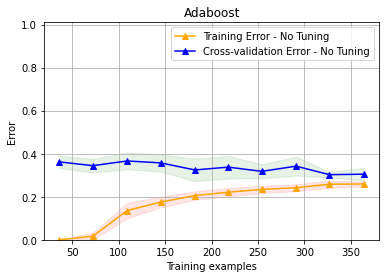

In [58]:
my_learn_curve(title="Adaboost", 
               estimator=liver_pipeline, 
               cv=stratified_kfold, 
               X=X_train,
               y=y_train,
               label_suffix="No Tuning", 
               color_=["orange","blue"],
               shape = '^-'  )

plt.savefig("ADABOOST_LIVER_TREE_BASE.pdf")

## Grid search booster Liver

In [40]:
AdaBoostClassifier?

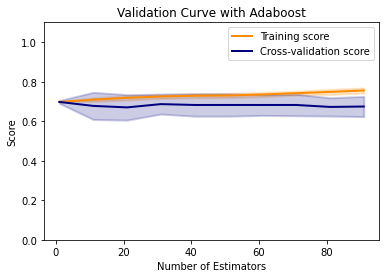

In [47]:

# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=45)
train_scores, valid_scores = validation_curve(liver_pipeline,
                                              X_train,
                                              y_train, 
                                              param_name = "model__n_estimators",
                                            param_range =np.array(range(1,100, 10)),
                                            cv=cv)

param_range = np.array(range(1,100, 10))

train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with Adaboost")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("ADA_LIVER_num_estimators.pdf")
plt.show()

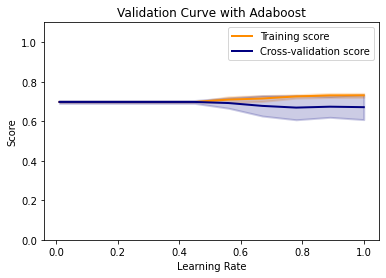

In [50]:
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=45)
train_scores, valid_scores = validation_curve(liver_pipeline,
                                              X_train,
                                              y_train, 
                                              param_name = "model__learning_rate",
                                            param_range = np.linspace(.01, 1.0, 10),
                                            cv=cv)

param_range = np.linspace(.01, 1.0, 10)
train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with Adaboost")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("ADA_LIVER_learning_rate.pdf")
plt.show()

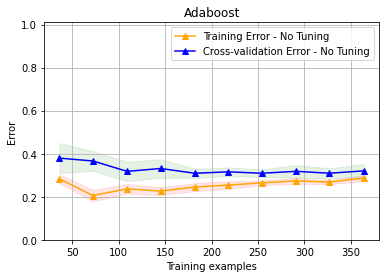

In [126]:

# example of grid searching key hyperparameters for adaboost on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
# define dataset
# define the model with default hyperparameters

model =  liver_pipeline
# define the grid of values to search
grid = dict()
grid['model__n_estimators'] = [i for i in range(1,12,1)]
grid['model__learning_rate'] = [0.01, .001, 0.1]
grid['model__base_estimator'] = [DecisionTreeClassifier(max_depth=max_depth_,
                                                 ccp_alpha=ccp, 
                                                 criterion=crit,
                                                 min_samples_leaf = min_samples_split_)  
                          for max_depth_ in range(1,4) 
                          for ccp in np.arange(0.0001, 0.051, 0.005)
                          for crit in ["entropy"]
                          for min_samples_split_ in range(6,16,2)
                           ]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=45)
# define the grid search procedure
grid_search_l= GridSearchCV(estimator=liver_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy')
# execute the grid search
grid_result_l = grid_search_l.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f usin g %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result_l.cv_results_['mean_test_score']
stds = grid_result_l.cv_results_['std_test_score']
params = grid_result_l.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.814455 usin g {'model__base_estimator': DecisionTreeClassifier(max_depth=9, min_samples_leaf=22), 'model__learning_rate': 0.1, 'model__n_estimators': 49}


In [ ]:
# Best: 0.632695 usin g {'model__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0101, criterion='entropy', max_depth=3,
#                        min_samples_leaf=14), 'model__learning_rate': 0.01, 'model__n_estimators': 5}

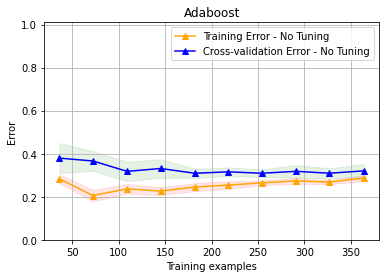

In [59]:
my_learn_curve(title="Adaboost", 
               estimator=grid_result.best_estimator_, 
               cv=stratified_kfold, 
               X=X_train,
               y=y_train,
               label_suffix="No Tuning", 
               color_=["orange","blue"],
               shape = '^-'  )


plt.savefig("ADABOOST_LIVER_TREE_final.pdf")


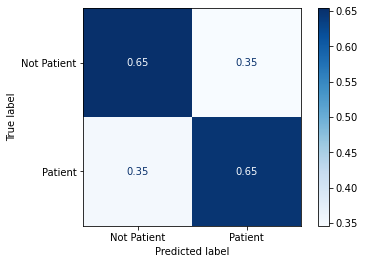

In [62]:
plot_confusion_matrix(estimator= ada, X=X_test, y_true= y_test  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )

In [118]:
average_precision_score(y_train, liver_pipeline.fit(X_train,y_train).predict_proba(X_train)[:,1])

0.8901518050476157

In [122]:
X_train.shape

(456, 10)

In [128]:
print(average_precision_score(y_train, grid_result_l.best_estimator_.predict_proba(X_train)[:,1]))
print(average_precision_score(y_test, grid_result_l.best_estimator_.predict_proba(X_test)[:,1]))

0.795761915661005
0.8313306510076846


In [56]:

print(grid_result.best_estimator_.get_params())
print(classification_report(y_train, grid_result.best_estimator_.predict(X_train) ))
print(classification_report(y_test, grid_result.best_estimator_.predict(X_test) ))

{'memory': None, 'steps': [('model', AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0101,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         min_samples_leaf=14),
                   learning_rate=0.01, n_estimators=5))], 'verbose': False, 'model': AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0101,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         min_samples_leaf=14),
                   learning_rate=0.01, n_estimators=5), 'model__algorithm': 'SAMME', 'model__base_estimator__ccp_alpha': 0.0101, 'model__base_estimator__class_weight': None, 'model__base_estimator__

In [9]:
base = AdaBoostClassifier(algorithm="SAMME", n_estimators=1)

mid = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(ccp_alpha=0.0031000000000000003,criterion='entropy',
                                                                 max_depth=2,
                                                                min_samples_split=10),
                                                                learning_rate=0.01, 
                                                                n_estimators=10, algorithm="SAMME")

overfit = AdaBoostClassifier(  n_estimators=200, algorithm="SAMME")

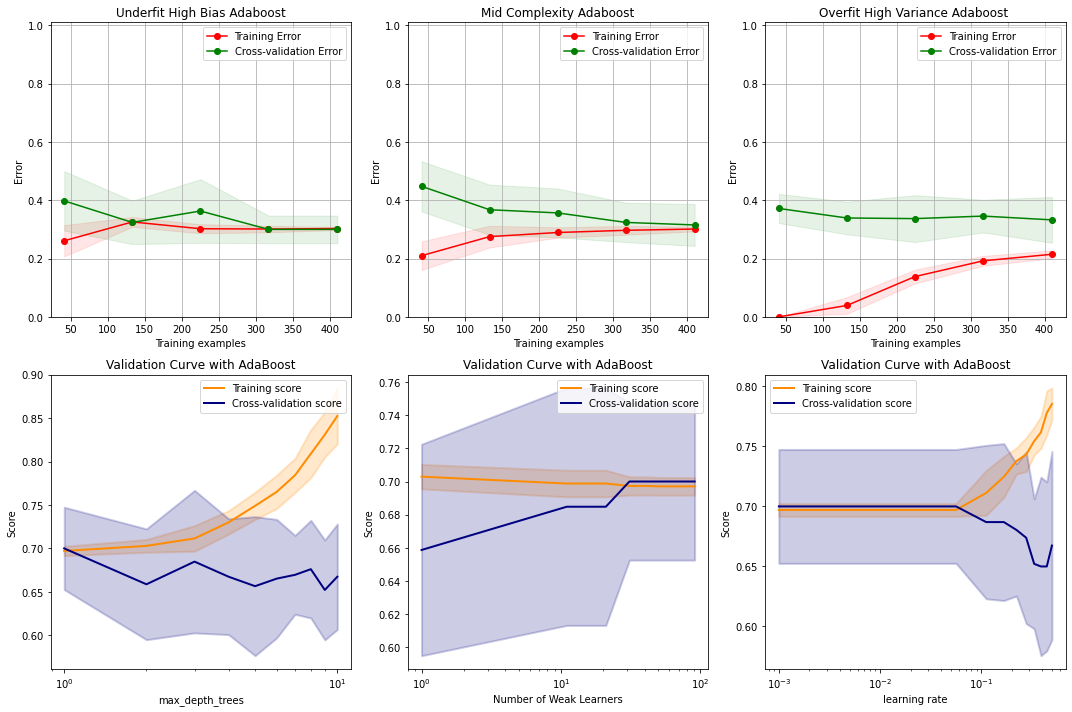

In [11]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#X, y = load_digits(return_X_y=True)


title = "Adaboost"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=14)

# def plot_learning_curve(estimator1, estimator2, title1, title2, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

# estimator =  AdaBoostClassifier
plot_learning_curve(estimator=base,
                    title="Underfit High Bias Adaboost",
                    X=X_train, 
                    y=y_train,
                    axes=axes[:,0], 
                    ylim=(0.0, 1.01),
                    cv=cv, 
                    n_jobs=4,
                    param_range = np.array(range(1,11)),
                    param_range_value = [DecisionTreeClassifier(max_depth=max_depth_ ,criterion="entropy") for max_depth_ in range(1,11)],
                    param_name = "base_estimator", 
                    validation_title="max_depth_trees")
        


plot_learning_curve(estimator=mid,
                    title="Mid Complexity Adaboost",
                    X=X_train, 
                    y=y_train,
                    axes=axes[:,1], 
                    ylim=(0.0, 1.01),
                    cv=cv, 
                    n_jobs=4,
                    param_range =  np.array(range(1,100, 10)),
                    param_range_value = np.array(range(1,100, 10)),
                    param_name = "n_estimators", 
                    validation_title="Number of Weak Learners")
        
plot_learning_curve(estimator=overfit,
                    title="Overfit High Variance Adaboost ",
                    X=X_train, 
                    y=y_train,
                    axes=axes[:,2], 
                    ylim=(0.0, 1.01),
                    cv=cv, 
                    n_jobs=4,
                    param_range = np.linspace(.001, .5, 10),
                    param_range_value =np.linspace(.01, 1.0, 10),
                    param_name = "learning_rate", 
                    validation_title="learning rate")
        

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)


plt.tight_layout()
plt.savefig("adaboost-comparison-bias-mid-overfit.pdf")
plt.show()

> **(large bias)**A model that is too simple can lead to an underadjustment .

 >**(high variance)** If the model is too complex for the underlying training data, over-fitting
 may occur

## Complexity Curves

## Complexity / Validation Curve 

In [ ]:
plot_confusion_matrix?

In [ ]:
print( f"Train Accuracy {round(sum(clf.predict(X_train)== y_train )/len(y_train),4)}")

In [ ]:
print( f"Test Accuracy {round(sum(clf.predict(X_test)== y_test )/len(y_test),4)}")

In [ ]:
ada.base_estimator.cost_complexity_pruning_path(X,y)

In [ ]:
# show accuracy has high false positives, use grid search on avg precision

>

> high bias more data doesnt help 
> High variance more data helps

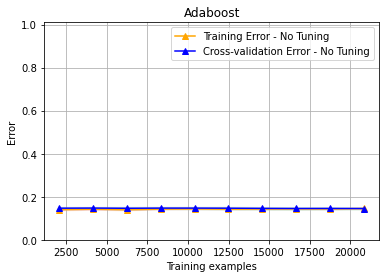

In [64]:
my_learn_curve(title="Adaboost", 
               estimator=census_pipeline, 
               cv=stratified_kfold,
               X=X_c_train,
               y=y_c_train,
               label_suffix="No Tuning", 
               color_=["orange","blue"],
               shape = '^-'  )

plt.savefig("ADABOOST_CENSUS_BASE_LEARNING_curve.pdf")

# complexity Census

In [71]:
import warnings
warnings.filterwarnings("ignore")

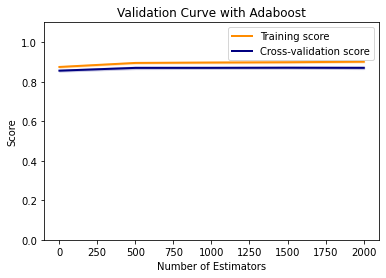

In [92]:
# Using pipeline
census_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('model',AdaBoostClassifier(algorithm="SAMME", n_estimators=1, learning_rate=.1, base_estimator=DecisionTreeClassifier(max_depth=10)))]
census_pipeline = Pipeline(steps=census_steps)
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
train_scores, valid_scores = validation_curve(census_pipeline,
                                              X_c_train,
                                              y_c_train, 
                                              param_name = "model__n_estimators",
                                            param_range =np.array(range(1,2002, 500)),
                                            cv=cv,
                                             n_jobs=-1)

param_range = np.array(range(1,2002, 500))

train_scores_mean =  np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with Adaboost")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# semilogx
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")


plt.savefig("ADA_census_num_estimators.pdf")
plt.show()

In [82]:
census_pipeline.get_params()

{'memory': None,
 'steps': [('encoding',
   OneHotEncoder(cols=Index(['workclass', 'education', 'marital.status', 'occupation',
          'relationship', 'race', 'sex', 'native.country'],
         dtype='object'))),
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('model',
   AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=1))],
 'verbose': False,
 'encoding': OneHotEncoder(cols=Index(['workclass', 'education', 'marital.status', 'occupation',
        'relationship', 'race', 'sex', 'native.country'],
       dtype='object')),
 'imputer': SimpleImputer(strategy='most_frequent'),
 'model': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=1),
 'encoding__cols': Index(['workclass', 'education', 'marital.status', 'occupation',
        'relationship', 'race', 'sex', 'native.country'],
       dtype='object'),
 'encoding__drop_invariant': False,
 'encoding__handle_missing': 'value',
 'encoding__handle_unknown': 'value',
 'encoding__return_df':

In [94]:
     
# example of grid searching key hyperparameters for adaboost on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
# define dataset
# define the model with default hyperparameters

model =  census_pipeline
# define the grid of values to search
grid = dict()
grid['model__n_estimators'] = [i for i in range(1,50,2)]
grid['model__learning_rate'] = [0.01, 0.1]
grid['model__base_estimator'] = [DecisionTreeClassifier(max_depth=max_depth_,
                                                 criterion=crit,
                                                 min_samples_leaf = min_samples_split_)  
                          for max_depth_ in range(2,10) 
                          for crit in ["gini"]
                          for min_samples_split_ in range(6,40,4)
                           ]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=45)
# define the grid search procedure
grid_search = GridSearchCV(estimator=census_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='average_precision')
# execute the grid search
grid_result = grid_search.fit(X_c_train, y_c_train)
# summarize the best score and configuration
print("Best: %f usin g %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.814455 usin g {'model__base_estimator': DecisionTreeClassifier(max_depth=9, min_samples_leaf=22), 'model__learning_rate': 0.1, 'model__n_estimators': 49}


In [96]:

# Best: 0.814455 usin g {'model__base_estimator': 
#DecisionTreeClassifier(max_depth=9, min_samples_leaf=22), 'model__learning_rate': 0.1, 'model__n_estimators': 49}

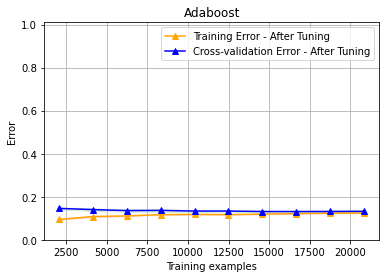

In [95]:
my_learn_curve(title="Adaboost", 
               estimator=grid_result.best_estimator_, 
               cv=stratified_kfold,
               X=X_c_train,
               y=y_c_train,
               label_suffix="After Tuning", 
               color_=["orange","blue"],
               shape = '^-'  )

plt.savefig("ADABOOST_CENSUS_final_LEARNING_curve.pdf")

In [104]:
# untuned precision training
average_precision_score(y_c_train, census_pipeline.fit(X_c_train,y_c_train).predict_proba(X_c_train)[:,1])

0.5967312531627624

In [101]:
print(average_precision_score(y_c_train, grid_result.predict_proba(X_c_train)[:,1]))
print(average_precision_score(y_c_test, grid_result.predict_proba(X_c_test)[:,1]))

0.8407571994770964
0.8096953202493742


In [99]:
print(classification_report(y_c_train, grid_result.best_estimator_.predict(X_c_train) ))
print(classification_report(y_c_test, grid_result.best_estimator_.predict(X_c_test) ))

              precision    recall  f1-score   support

          -1       0.89      0.95      0.92     19758
           1       0.79      0.64      0.71      6271

    accuracy                           0.87     26029
   macro avg       0.84      0.80      0.82     26029
weighted avg       0.87      0.87      0.87     26029

              precision    recall  f1-score   support

          -1       0.89      0.94      0.92      4940
           1       0.78      0.63      0.70      1568

    accuracy                           0.87      6508
   macro avg       0.83      0.79      0.81      6508
weighted avg       0.86      0.87      0.86      6508



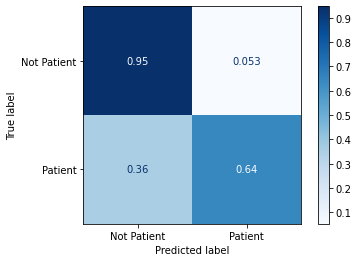

In [97]:
plot_confusion_matrix(estimator=  census_pipeline.fit(X_c_train,y_c_train) ,
                      X=X_c_train,
                      y_true= y_c_train  , 
                      cmap=plt.cm.Blues,
                       normalize="true",
                      display_labels = ["Not Patient" ,"Patient"]
                        )